In [1]:
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import json
import urllib.request


#### Lab 10: Gradcam

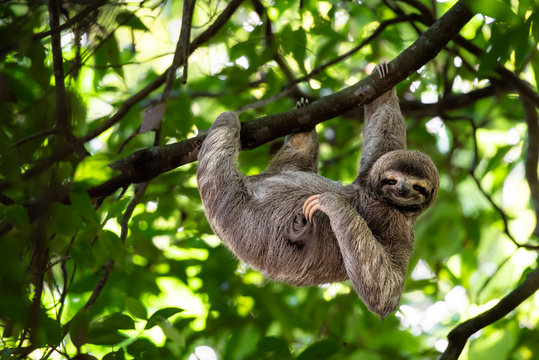

In [2]:
# --------- Step 1: Load and preprocess the image ---------
image_path = "sloth.png"  # Replace with actual image path
image = Image.open(image_path)
image 

In [3]:
# --------- Step 2: Resize, normalize and put into input_tensor---------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

## format (C x H x W, where C=3 for RGB)
##add an exter dim for batch process -even though its only one image
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

In [4]:
# --------- Step 3: Load pretrained model ---------
model = models.resnet50(models.ResNet50_Weights.DEFAULT).eval()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [5]:
# --------- Step 4: Hook into model --------- 
gradients = []
activations = []

def save_gradient(module, grad_input, grad_output):
    gradients.append(grad_output[0])

def save_activation(module, input, output):
    activations.append(output)


In [6]:
# --------- Step 5: Registering Hooks to Capture Activations and Gradients ---------

# Choose a target layer (last conv layer)
##uncomment 
target_layer = model.layer4[2].conv3

'''
Some background:
attaching hooks to a specific layer — in this case last convolution layer, 
so we can capture data during the forward and backward pass.

'''
##uncomment 
target_layer.register_forward_hook(save_activation)
target_layer.register_backward_hook(save_gradient)


In [7]:
# --------- Step 6: Forward and backward pass ---------
##uncomment 
output = model(image_tensor)
class_idx = output.argmax().item()  # Get top predicted class
score = output[0, class_idx]
##clear out the previous gradients
model.zero_grad()
##start backprop
score.backward()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


In [8]:
# --------- Step 7: Compute Grad-CAM ---------
#Get saved activations and gradients for the input image
#These were stored via forward and backward hooks on the last conv layer
##uncomment
grad = gradients[0].detach()
act = activations[0].detach()

#Global average pooling on gradients to get weights (αₖ)
#This gives the importance of each feature map for the target class
##uncomment
weights = grad.mean(dim=(2, 3), keepdim=True)  # Global avg pooling

###Weighted sum of activations###
# Multiply each feature map by its corresponding weight, then sum them
##uncomment
grad_cam = F.relu((weights))

##Upsample the Grad-CAM heatmap to the input image size
grad_cam = F.interpolate(grad_cam, size=(224, 224), mode='bilinear', align_corners=False)

##Remove extra dimensions and convert to NumPy array for visualization
grad_cam = grad_cam.squeeze().numpy()


In [9]:
# --------- Step 8: Normalize for heatmap ---------
grad_cam -= grad_cam.min()
grad_cam /= grad_cam.max()


In [11]:
# --------- Step 9: Load ImageNet class labels ---------
##uncomment
url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
labels_path = "imagenet_classes.txt"

# # Download if not already present
try:
    with open(labels_path, "r") as f:
        classes = [line.strip() for line in f.readlines()]
except FileNotFoundError:
    urllib.request.urlretrieve(url, labels_path)
    with open(labels_path, "r") as f:
        classes = [line.strip() for line in f.readlines()]

predicted_label = classes[class_idx]
print(f"Predicted Class: {predicted_label} (index: {class_idx})")

Predicted Class: three-toed sloth (index: 364)


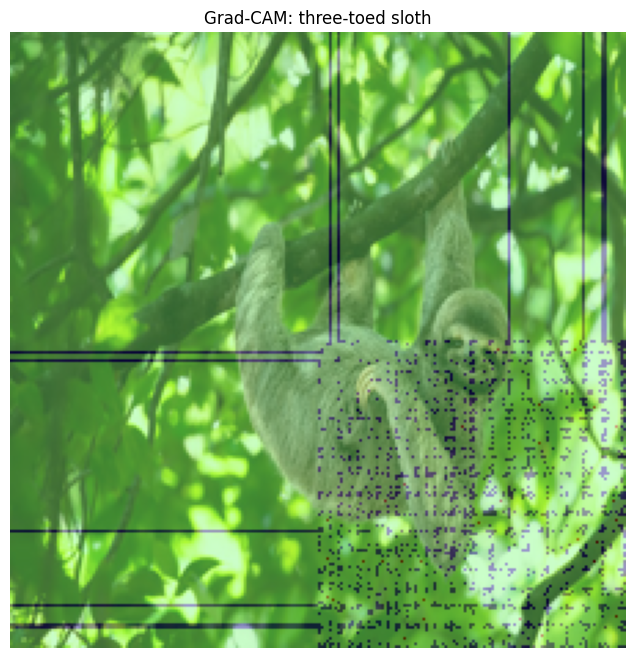

In [17]:
# --------- Step 10: Create heatmap and overlay ---------
##uncomment
# # Resize original image
img_resized = image.resize((224, 224))
img_np = np.array(img_resized) / 255.0  # Normalize to [0, 1]


heatmap_2d = np.mean(grad_cam, axis = 0)

heatmap_2d = (heatmap_2d - np.min(heatmap_2d)) / (np.max(heatmap_2d) - np.min(heatmap_2d))

# # Create colored heatmap using matplotlib
heatmap_colored = plt.cm.jet(heatmap_2d)[:, :, :3]  # Remove alpha channel  

# # Blend heatmap and original image
overlay = 0.4 * heatmap_colored + 0.6 * img_np
overlay = np.clip(overlay, 0, 1)

# # --------- Step 8: Display the result ---------
plt.figure(figsize=(8, 8))
plt.imshow(overlay)
plt.title(f"Grad-CAM: {predicted_label}")
plt.axis("off")
plt.show()
